# Data Analysis - Experiments

In [15]:
import os
import re
from typing import Dict, Tuple, List
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
SQUARE_DATA_DIR = './data/square'
HEX_DATA_DIR = './data/hex'
TRIANGLE_DATA_DIR = './data/triangle'
DATA_DIR = './data'

## Util functions

In [17]:
def parse_filename(filename: str) -> Tuple[str, int, int]:
    match = re.match(r"expectimax_([a-z_]+)_depth_(\d+)_([a-z]+)_size_(\d+)\.csv", filename)
    if match:
        heuristic, depth, board_type, size = match.groups()
        return heuristic, int(depth), int(size)
    match = re.match(r"random_([a-z]+)_size_(\d+)\.csv", filename)
    if match:
        board_type, size = match.groups()
        return 'random', 0, int(size)
    raise ValueError(f"Unrecognized filename: {filename}")

def load_datasets(data_dir: str) -> Dict[str, Dict[str, Dict[int, pd.DataFrame]]]:
    """
    Loads datasets into a nested dict: datasets[board_type][heuristic][depth] = DataFrame
    """
    datasets: Dict[str, Dict[str, Dict[int, pd.DataFrame]]] = {}
    for board_type in os.listdir(data_dir):
        board_path = os.path.join(data_dir, board_type)
        if not os.path.isdir(board_path):
            continue
        for fname in os.listdir(board_path):
            if not fname.endswith('.csv'):
                continue
            try:
                heuristic, depth, size = parse_filename(fname)
            except ValueError:
                continue
            if board_type not in datasets:
                datasets[board_type] = {}
            if heuristic not in datasets[board_type]:
                datasets[board_type][heuristic] = {}
            df = pd.read_csv(os.path.join(board_path, fname))
            datasets[board_type][heuristic][depth] = df
    return datasets


## Plot functions

To compare different heuristics for the same topology

In [18]:
def prepare_violin_plot_data(
    heuristics_dfs: Dict[str, Dict[int, pd.DataFrame]],
    metric: str,
    random_df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Prepare a DataFrame for violin plot with values of the specified metric
    for all heuristics and depths, including optional random baseline.
    """
    plot_data = []

    for heuristic, dfs in heuristics_dfs.items():
        if heuristic == 'random':
            continue
        for depth, df in dfs.items():
            vals = df[metric]
            if metric == 'max_tile':
                vals = np.log2(vals)
            for val in vals:
                plot_data.append({
                    'heuristic': heuristic,
                    'depth': depth,
                    'value': val,
                    'category': f'{heuristic}_d{depth}'
                })

    if random_df is not None:
        vals = random_df[metric]
        if metric == 'max_tile':
            vals = np.log2(vals)
        for val in vals:
            plot_data.append({
                'heuristic': 'random',
                'depth': 0,
                'value': val,
                'category': 'random'
            })

    return pd.DataFrame(plot_data)


def plot_metric_all_heuristics(
    plot_df: pd.DataFrame,
    metric: str,
    board_type: str,
    heuristics_dfs: Dict[str, Dict[int, pd.DataFrame]],
    random_df: pd.DataFrame = None
) -> None:
    """
    Plot violin plots for the given metric using the prepared DataFrame,
    with comparisons between heuristics and an optional random baseline.
    """
    plt.figure(figsize=(14, 8))

    desired_order = ["random", "empty_cells", "snake"]
    heuristics = [h for h in desired_order if h in heuristics_dfs.keys() and h != 'random']
    all_depths = sorted(next((dfs for h, dfs in heuristics_dfs.items() if h != 'random'), None).keys())

    positions = []
    labels = []
    colors_list = []
    colors = plt.cm.get_cmap('tab10')
    pos = 0

    if random_df is not None:
        positions.append(pos)
        labels.append('random')
        colors_list.append('tab:red')
        pos += 1.5

    for heuristic_idx, heuristic in enumerate(heuristics):
        for depth in all_depths:
            positions.append(pos)
            labels.append(f'{heuristic}\nd{depth}')
            colors_list.append(colors(heuristic_idx + 1))
            pos += 1
        pos += 0.5

    violin_data = []

    if random_df is not None:
        random_data = plot_df[plot_df['heuristic'] == 'random']['value']
        violin_data.append(random_data.values)

    for heuristic in heuristics:
        for depth in all_depths:
            data = plot_df[(plot_df['heuristic'] == heuristic) & (plot_df['depth'] == depth)]['value']
            violin_data.append(data.values)

    parts = plt.violinplot(violin_data, positions=positions, widths=0.8, showmeans=True, showmedians=True)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors_list[i])
        pc.set_alpha(0.7)

    plt.xticks(positions, labels, rotation=45, ha='right')
    plt.xlabel('Heuristic and Depth')
    title_label = 'log2(max_tile)' if metric == 'max_tile' else metric
    plt.ylabel(title_label)
    plt.title(f'{board_type} - All heuristics vs random: {title_label} distributions across depths')

    legend_elements = []
    if random_df is not None:
        legend_elements.append(plt.Line2D([0], [0], color='tab:red', lw=4, label='random'))
    for idx, heuristic in enumerate(heuristics):
        legend_elements.append(plt.Line2D([0], [0], color=colors(idx + 1), lw=4, label=heuristic))

    plt.legend(handles=legend_elements, loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


To compare differents topologies

In [24]:
def prepare_tile_record_data(
    heuristics_dfs: Dict[str, Dict[int, pd.DataFrame]],
    thresholds: List[int],
    random_df: pd.DataFrame = None
) -> Tuple[Dict[int, List[float]], List[str], Dict[str, str]]:
    """
    Prepara os dados para o gráfico de tile records.

    Returns:
        tile_data: Dict com chave sendo o valor da tile (2^threshold) e valores as porcentagens.
        algorithms: Lista com os nomes dos algoritmos formatados para o gráfico.
        colors_map: Mapeamento de algoritmos para suas cores.
    """
    desired_order = ["random", "empty_cells", "snake"]
    heuristics = [h for h in desired_order if h in heuristics_dfs.keys() and h != 'random']
    all_depths = sorted(next((dfs for h, dfs in heuristics_dfs.items() if h != 'random'), None).keys())

    algorithms = []
    colors_map = {}

    if random_df is not None:
        algorithms.append('Random')
        colors_map['Random'] = '#A9A9A9'

    heuristic_colors = {'empty_cells': '#FFD700', 'snake': '#FF8C00'}
    for heuristic in heuristics:
        for depth in all_depths:
            algo_name = f'{heuristic.title()}_d{depth}'
            algorithms.append(algo_name)
            colors_map[algo_name] = heuristic_colors.get(heuristic, '#FF6347')

    tile_data = {}
    for threshold in thresholds:
        tile_value = int(2 ** threshold)
        percentages = []

        if random_df is not None:
            log_max_tiles = np.log2(random_df['max_tile'])
            pct = (log_max_tiles >= threshold).mean() * 100
            percentages.append(pct)

        for heuristic in heuristics:
            for depth in all_depths:
                df = heuristics_dfs[heuristic][depth]
                log_max_tiles = np.log2(df['max_tile'])
                pct = (log_max_tiles >= threshold).mean() * 100
                percentages.append(pct)

        tile_data[tile_value] = percentages

    return tile_data, algorithms, colors_map


def plot_tile_records_horizontal(
    heuristics_dfs: Dict[str, Dict[int, pd.DataFrame]],
    board_type: str,
    thresholds: List[int] = [8, 9, 10, 11, 12],
    random_df: pd.DataFrame = None
) -> None:
    """
    Plota gráfico horizontal com a porcentagem de jogos que atingiram cada tile threshold.
    """
    tile_data, algorithms, colors_map = prepare_tile_record_data(
        heuristics_dfs, thresholds, random_df
    )

    plt.figure(figsize=(12, 8))
    tile_values = [int(2 ** t) for t in sorted(thresholds, reverse=True)]
    n_algorithms = len(algorithms)
    bar_height = 0.8 / n_algorithms

    for i, algo in enumerate(algorithms):
        percentages = [tile_data[tile][i] for tile in tile_values]
        y_positions = np.arange(len(tile_values)) + (i - n_algorithms / 2 + 0.5) * bar_height

        bars = plt.barh(y_positions, percentages, height=bar_height,
                        color=colors_map[algo], alpha=0.8, label=algo)

        for bar, pct in zip(bars, percentages):
            if pct > 2:
                plt.text(pct + 1, bar.get_y() + bar.get_height() / 2,
                         f'{pct:.1f}%', ha='left', va='center', fontsize=9)

    plt.yticks(np.arange(len(tile_values)), [str(tile) for tile in tile_values])
    plt.xlabel('Percentage (%)')
    plt.ylabel('Tile Value')
    plt.title(f'Tiles Frequency - {board_type}', fontsize=16, fontweight='bold', color='#333333')
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 20), [f'{x}%' for x in range(0, 101, 20)])
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.gca().set_axisbelow(True)
    plt.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

## Analysis

In [20]:
datasets = load_datasets(DATA_DIR)

Comparing different heuristics

C:\Users\luizg\AppData\Local\Temp\ipykernel_4216\200483998.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


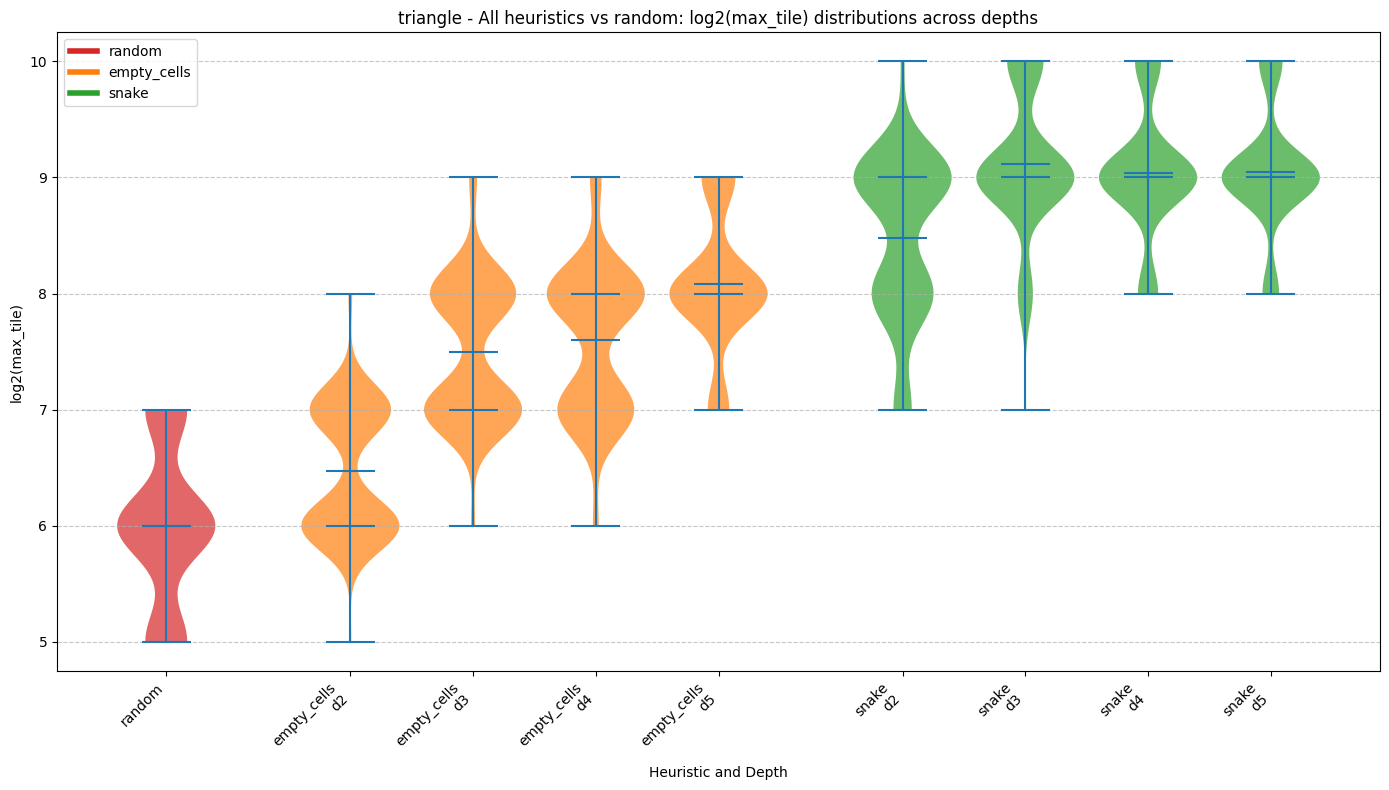

C:\Users\luizg\AppData\Local\Temp\ipykernel_4216\200483998.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


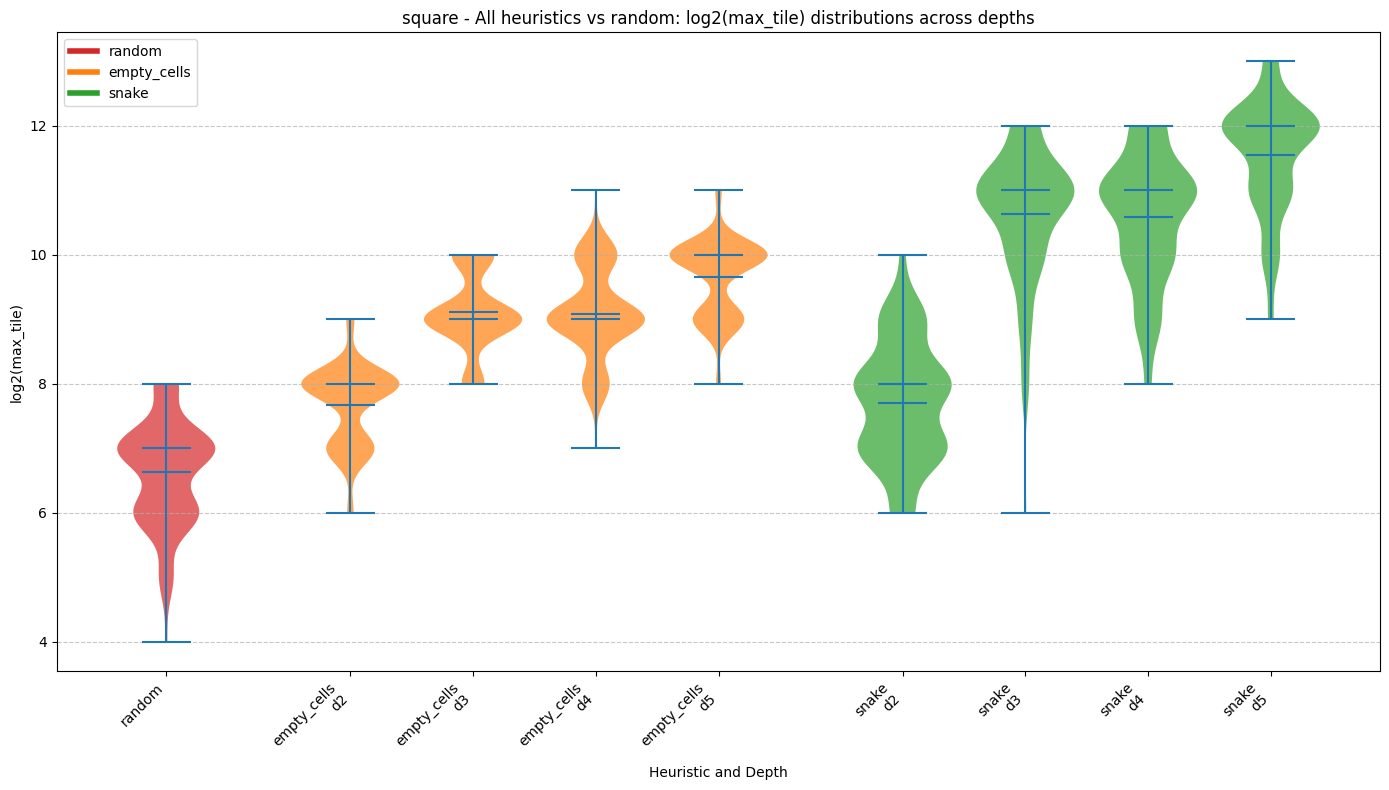

In [21]:
for board_type, heuristics in datasets.items():
    if board_type == 'hex':
        continue
    random_df = heuristics['random'][0] if 'random' in heuristics and 0 in heuristics['random'] else None
    plot_df = prepare_violin_plot_data(heuristics_dfs=heuristics, metric="max_tile", random_df=random_df)
    plot_metric_all_heuristics(
        plot_df=plot_df,
        heuristics_dfs=heuristics,
        metric="max_tile",
        board_type=board_type,
        random_df=random_df
    )


Comparing different topologies

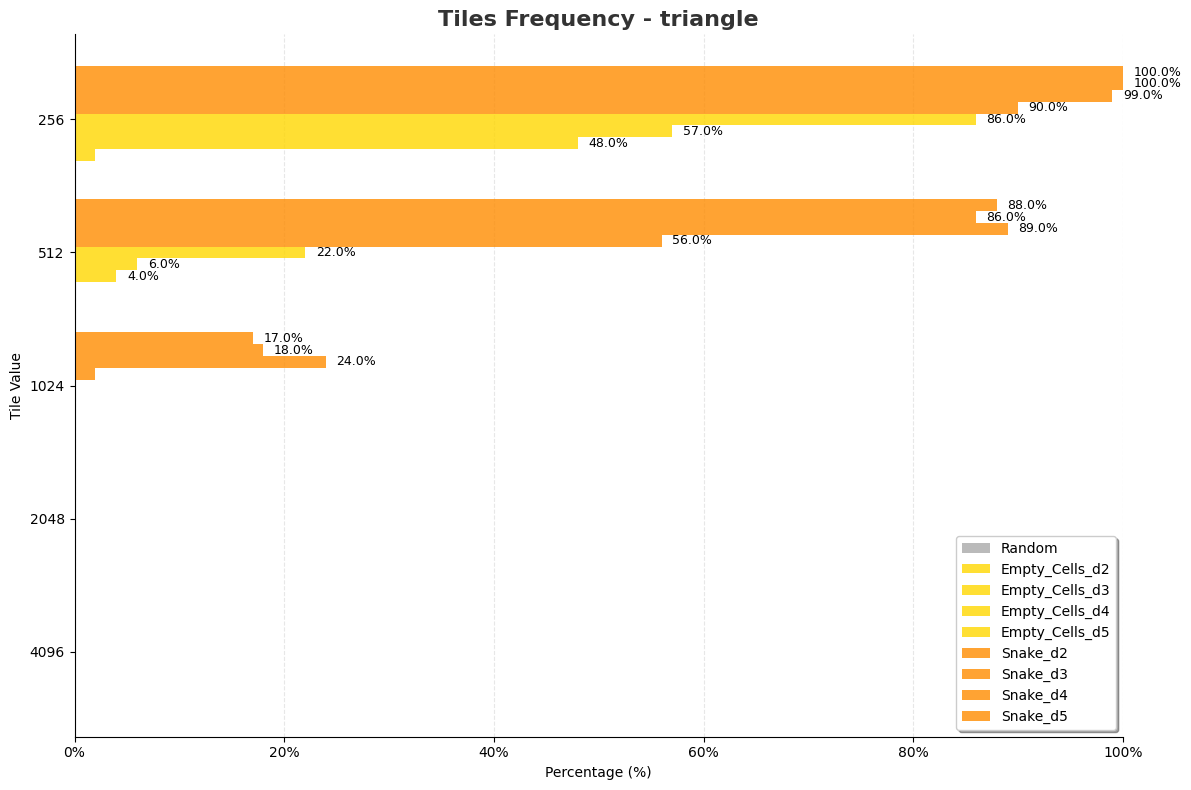

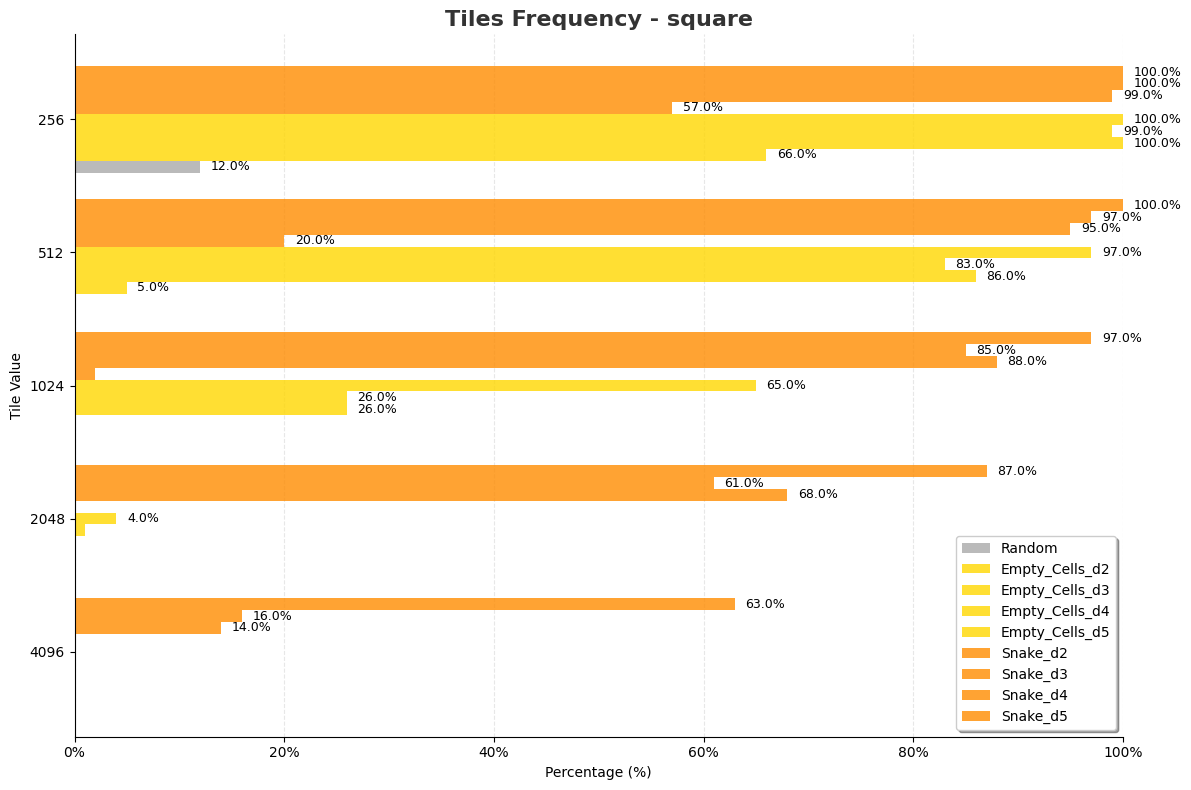

In [25]:
for board_type, heuristics in datasets.items():
    if board_type == 'hex':
        continue
    random_df = heuristics['random'][0] if 'random' in heuristics and 0 in heuristics['random'] else None
    plot_tile_records_horizontal(
        heuristics,
        board_type=board_type,
        random_df=random_df
    )